# Deriving a vegetation index from PlanetScope imagery

The GNDVI is calculated between Green and NIR bands. 
 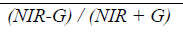

##  Extract the data from the green and near-infrared bands 



In this step, you'll use [Rasterio](https://github.com/mapbox/rasterio), a Python library for reading and writing geospatial raster datasets, to open the raster image you downloaded (the .tif file). Then you'll extract the data from the red and near-infrared bands and load the band data into arrays that you can manipulate using Python's [NumPy](http://www.numpy.org/) libary. *Note: in PlanetScope 4-band images, the band order is BGRN: (1) Blue, (2) Green, (3) Red, (4) Near-infrared.*

In [1]:
import rasterio
import numpy as np

filename = "20200406_035417_0f2b_3B_AnalyticMS.tif"

# Load red,blue and NIR bands - note all PlanetScope 4-band images have band order BGRN
# Load green and NIR bands - note all PlanetScope 4-band images have band order BGRN

    
with rasterio.open(filename) as src:
    band_green = src.read(2)

with rasterio.open(filename) as src:
    band_nir = src.read(4)

##  Normalize the band data

Before you can calculate GNDVI, you must normalize the values in the arrays for each band using the [Top of Atmosphere (TOA) reflectance coefficients](https://landsat.usgs.gov/using-usgs-landsat-8-product) stored in metadata file you downloaded (the .xml file).

In [2]:
from xml.dom import minidom

xmldoc = minidom.parse("20200406_035417_0f2b_3B_AnalyticMS_metadata.xml")
nodes = xmldoc.getElementsByTagName("ps:bandSpecificMetadata")

# XML parser refers to bands by numbers 1-4
coeffs = {}
for node in nodes:
    bn = node.getElementsByTagName("ps:bandNumber")[0].firstChild.data
    if bn in ['1', '2', '3', '4']:
        i = int(bn)
        value = node.getElementsByTagName("ps:reflectanceCoefficient")[0].firstChild.data
        coeffs[i] = float(value)
        
# Multiply the Digital Number (DN) values in each band by the TOA reflectance coefficients

band_green = band_green * coeffs[2]
band_nir = band_nir * coeffs[4]

##  Perform the GNDVI calculation

Next, you're going to calculate GNDVI through subtraction and division of the normalized values stored in the NumPy arrays. This calculation will give you NDVI values that range from -1 to 1. Values closer to 1 indicate a greater density of vegetation or higher level of "greenness."

In [3]:
# Allow division by zero
np.seterr(divide='ignore', invalid='ignore')

# Calculate GNDVI. This is the equation at the top of this guide expressed in code
gndvi = (band_nir.astype(float) - band_green.astype(float)) / (band_nir.astype(float) + band_green.astype(float))

In [4]:
# check range NDVI values, excluding NaN
np.nanmin(gndvi), np.nanmax(gndvi)

(-0.5241789710179732, 0.5581800158538911)

##  Save the GNDVI image 

Next, you're going to save the calculated GNDVI values to a new image file, making sure the new image file has the same geospatial metadata as the original GeoTIFF we downloaded.

In [5]:
# Set spatial characteristics of the output object to mirror the input
kwargs = src.meta
kwargs.update(
    dtype=rasterio.float32,
    count = 1)

# Write band calculations to a new raster file
with rasterio.open('gndvi_20200406_mumbai.tif', 'w', **kwargs) as dst:
        dst.write_band(1, gndvi.astype(rasterio.float32))

C:\ProgramData\Anaconda3\lib\site-packages\rasterio\__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


## Step 6. Apply a color scheme to visualize the GNDVI values on the image

In the last two steps, you'll use [Matplotlib](https://matplotlib.org/) to visualize the GNDVI values you calculated for the PlanetScope scene. First you'll view a map of the EVI values; then you'll generate a histogram of NDVI values. 

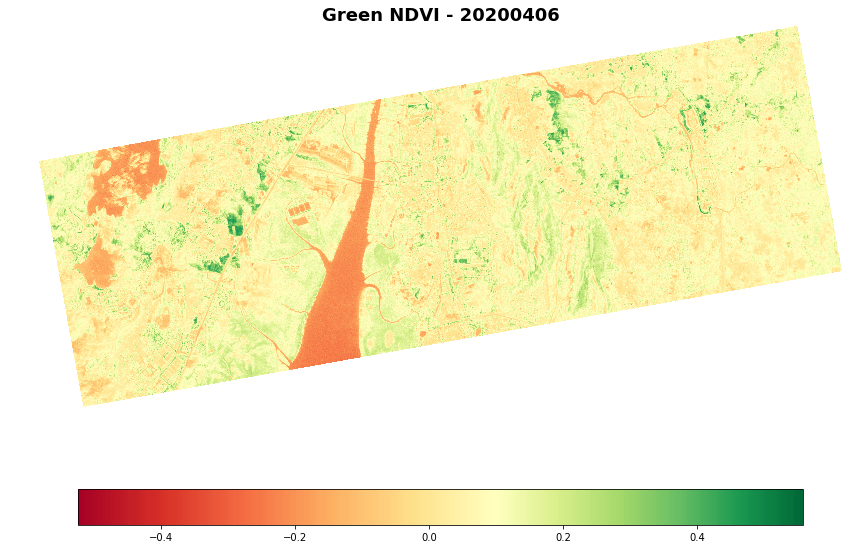

In [7]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

"""
The GNDVI values will range from -1 to 1. You want to use a diverging color scheme to visualize the data,
and you want to center the colorbar at a defined midpoint. The class below allows you to normalize the colorbar.
"""

class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)
    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    Credit: Joe Kington, http://chris35wills.github.io/matplotlib_diverging_colorbar/
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))


# Set min/max values from NDVI range for image (excluding NAN)
# set midpoint according to how NDVI is interpreted: https://earthobservatory.nasa.gov/Features/MeasuringVegetation/
min=np.nanmin(gndvi)
max=np.nanmax(gndvi)
mid=0.1

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

# diverging color scheme chosen from https://matplotlib.org/users/colormaps.html
cmap = plt.cm.RdYlGn 

cax = ax.imshow(gndvi, cmap=cmap, clim=(min, max), norm=MidpointNormalize(midpoint=mid,vmin=min, vmax=max))

ax.axis('off')
ax.set_title('Green NDVI - 20200406', fontsize=18, fontweight='bold')

cbar = fig.colorbar(cax, orientation='horizontal', shrink=0.65)

fig.savefig("gndvi_20200406_mumbai.png", dpi=200, bbox_inches='tight', pad_inches=0.7)

plt.show()

##  Generate a histogram of EVI values

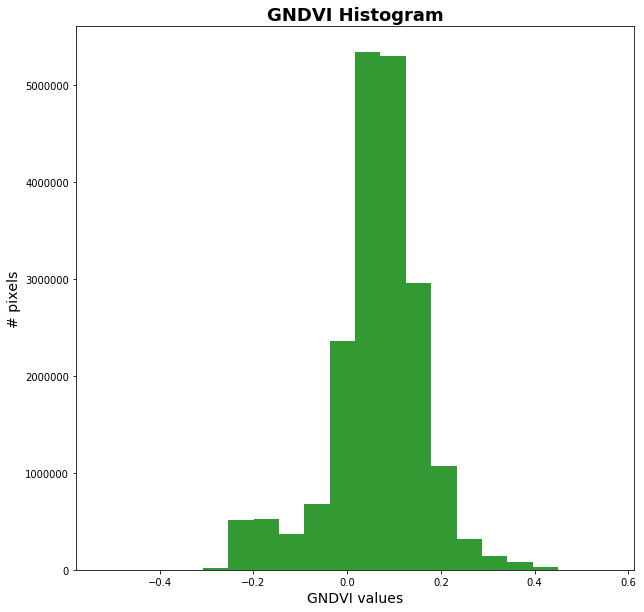

In [8]:
fig2 = plt.figure(figsize=(10,10))
ax = fig2.add_subplot(111)

plt.title("GNDVI Histogram", fontsize=18, fontweight='bold')
plt.xlabel("GNDVI values", fontsize=14)
plt.ylabel("# pixels", fontsize=14)


x = gndvi[~np.isnan(gndvi)]
numBins = 20
ax.hist(x,numBins,color='green',alpha=0.8)

fig2.savefig("gndvi-histogram_20200406_mumbai.png", dpi=200, bbox_inches='tight', pad_inches=0.7)

plt.show()

In [16]:
import rasterio
import numpy as np

filename1 = "20200611_034457_1054_3B_AnalyticMS.tif"

# Load red,blue  and NIR bands - note all PlanetScope 4-band images have band order BGRN
    
with rasterio.open(filename1) as src:
    band_green1 = src.read(2)

with rasterio.open(filename1) as src:
    band_nir1 = src.read(4)

In [17]:
from xml.dom import minidom

xmldoc = minidom.parse("20200611_034457_1054_3B_AnalyticMS_metadata.xml")
nodes = xmldoc.getElementsByTagName("ps:bandSpecificMetadata")

# XML parser refers to bands by numbers 1-4
coeffs = {}
for node in nodes:
    bn = node.getElementsByTagName("ps:bandNumber")[0].firstChild.data
    if bn in ['1', '2', '3', '4']:
        i = int(bn)
        value = node.getElementsByTagName("ps:reflectanceCoefficient")[0].firstChild.data
        coeffs[i] = float(value)
        
# Multiply the Digital Number (DN) values in each band by the TOA reflectance coefficients

band_green1 = band_green1 * coeffs[3]
band_nir1 = band_nir1 * coeffs[4]

In [18]:
# Allow division by zero
np.seterr(divide='ignore', invalid='ignore')

# Calculate GNDVI. This is the equation at the top of this guide expressed in code
gndvi1 = (band_nir1.astype(float) - band_green1.astype(float)) / (band_nir1.astype(float) + band_green1.astype(float))

# check range GNDVI values, excluding NaN
np.nanmin(gndvi1), np.nanmax(gndvi1)

# Set spatial characteristics of the output object to mirror the input
kwargs = src.meta
kwargs.update(
    dtype=rasterio.float32,
    count = 1)

# Write band calculations to a new raster file
with rasterio.open('gndvi_20200611_mumbai.tif', 'w', **kwargs) as dst:
        dst.write_band(1, gndvi1.astype(rasterio.float32))

C:\ProgramData\Anaconda3\lib\site-packages\rasterio\__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


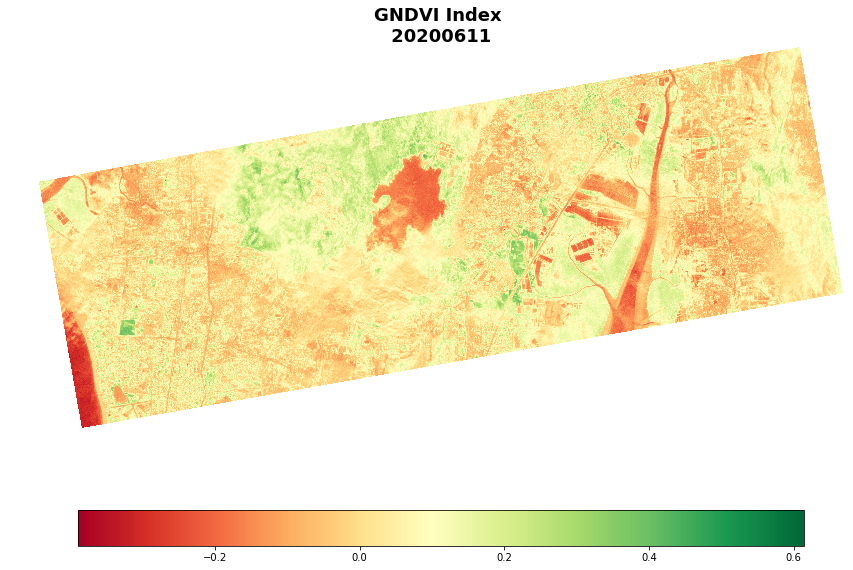

In [19]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

"""
The gndVI values will range from -1 to 1. You want to use a diverging color scheme to visualize the data,
and you want to center the colorbar at a defined midpoint. The class below allows you to normalize the colorbar.
"""

class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)
    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    Credit: Joe Kington, http://chris35wills.github.io/matplotlib_diverging_colorbar/
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))


# Set min/max values from EVI range for image (excluding NAN)
# set midpoint according to how EVI is interpreted: https://earthobservatory.nasa.gov/Features/MeasuringVegetation/
min=np.nanmin(gndvi1)
max=np.nanmax(gndvi1)
mid=0.1

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

# diverging color scheme chosen from https://matplotlib.org/users/colormaps.html
cmap = plt.cm.RdYlGn 

cax = ax.imshow(gndvi1, cmap=cmap, clim=(min, max), norm=MidpointNormalize(midpoint=mid,vmin=min, vmax=max))

ax.axis('off')
#x = ndvi1[~np.isnan(ndvi1)]
#ax.set_title('Coverage\n(median: {})'.format(int(np.median(coverage))))
# ax.set_title('Normalized Difference Vegetation Index - 20200611 \n (median: {})'.format(int(np.median(x))), fontsize=18, fontweight='bold')
ax.set_title('GNDVI Index \n 20200611 ', fontsize=18, fontweight='bold')

cbar = fig.colorbar(cax, orientation='horizontal', shrink=0.65)

fig.savefig("gndvi_20200611_mumbai.png", dpi=200, bbox_inches='tight', pad_inches=0.7)

plt.show()

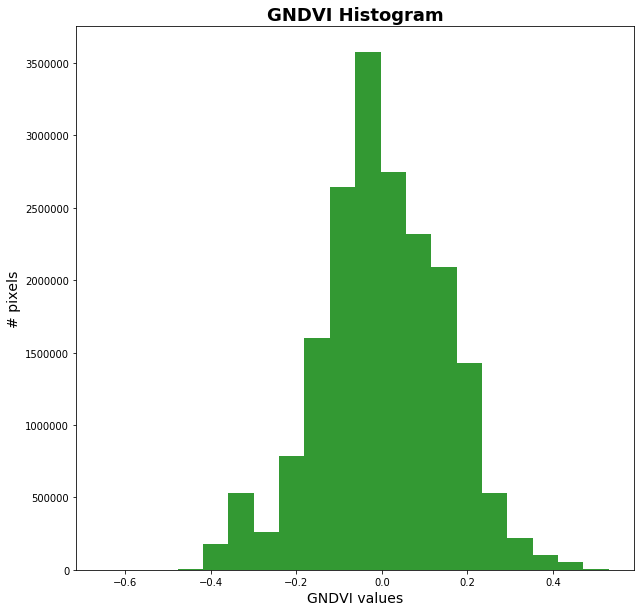

In [15]:
fig2 = plt.figure(figsize=(10,10))
ax = fig2.add_subplot(111)

plt.title("GNDVI Histogram", fontsize=18, fontweight='bold')
plt.xlabel("GNDVI values", fontsize=14)
plt.ylabel("# pixels", fontsize=14)


x = gndvi1[~np.isnan(gndvi1)]
numBins = 20
ax.hist(x,numBins,color='green',alpha=0.8)

fig2.savefig("gndvi-histogram_20200611_mumbai.png", dpi=200, bbox_inches='tight', pad_inches=0.7)

plt.show()

### Dense Vegetation > 0.7
### Medium Vegetation 0.5-0.7
### Sparse Vegetation 0.3-0.5
### No Vegetation 0.1-0.3
### Water Bodies < 0.1

In [63]:
x = ndvi[~np.isnan(ndvi)]
x1 = ndvi1[~np.isnan(ndvi1)]
print(x,x.shape)
print(x1,x1.shape)
w = x[:18988549]
w1 = x1[:18988549]
z = w1-w
#w = (x - x1[:,None]).shape


[0.15802664 0.1543668  0.15559498 ... 0.05542309 0.04948519 0.049159  ] (19698670,)
[ 0.22111975  0.22275504  0.23148339 ... -0.15070793 -0.17919025
 -0.19366044] (18988549,)


In [68]:
first_median = np.median(w)
first_median

0.1336847885874625

In [69]:
second_median = np.median(w1)
second_median

0.1729497995252803

In [71]:
increase = second_median - first_median
print("Increase/Decrease value = ",increase)
result = (increase/first_median) *100
print("Percentage of increase/decrease = ",result)

Increase/Decrease value =  0.03926501093781781
Percentage of increase/decrease =  29.371337870747283


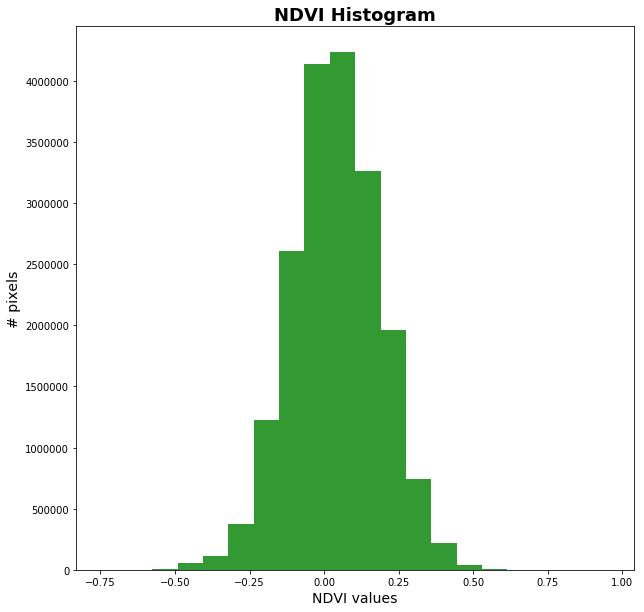

In [67]:
fig2 = plt.figure(figsize=(10,10))
ax = fig2.add_subplot(111)

plt.title("NDVI Histogram", fontsize=18, fontweight='bold')
plt.xlabel("NDVI values", fontsize=14)
plt.ylabel("# pixels", fontsize=14)



numBins = 20
ax.hist(z,numBins,color='green',alpha=0.8)

fig2.savefig("ndvi-histogram_diff_mumbai.png", dpi=200, bbox_inches='tight', pad_inches=0.7)

plt.show()